Enter Stock Symbol (e.g., AAPL, GOOG, TSLA): TSLA


/tmp/ipython-input-1-431778656.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start, end)
[*********************100%***********************]  1 of 1 completed



Showing recent data for TSLA:
Price        Date       Close        High         Low        Open     Volume
Ticker                   TSLA        TSLA        TSLA        TSLA       TSLA
2763   2022-12-23  123.150002  128.619995  121.019997  126.370003  166989700
2764   2022-12-27  109.099998  119.669998  108.760002  117.500000  208643400
2765   2022-12-28  112.709999  116.269997  108.239998  110.349998  221070500
2766   2022-12-29  121.820000  123.570000  117.500000  120.389999  221923300
2767   2022-12-30  123.180000  124.480003  119.750000  119.949997  157777300

Decomposing time series into trend, seasonality, and residuals...
Figure(640x480)


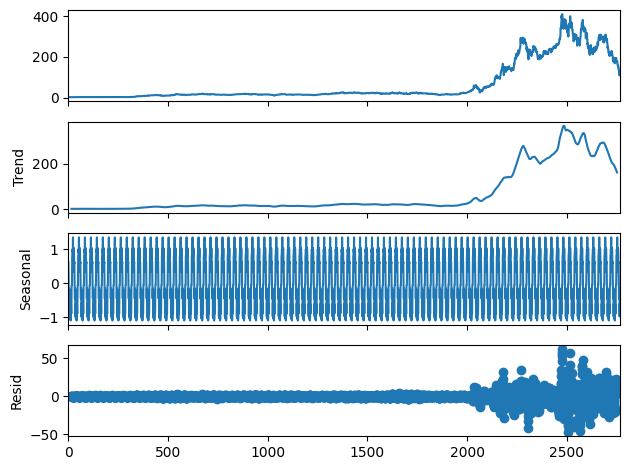

/tmp/ipython-input-1-431778656.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_feat.dropna(inplace=True)



Training SARIMAX model...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Evaluation Metrics:
Mean Squared Error (MSE): 115.56
Mean Absolute Error (MAE): 9.12
R² Score: 0.9672


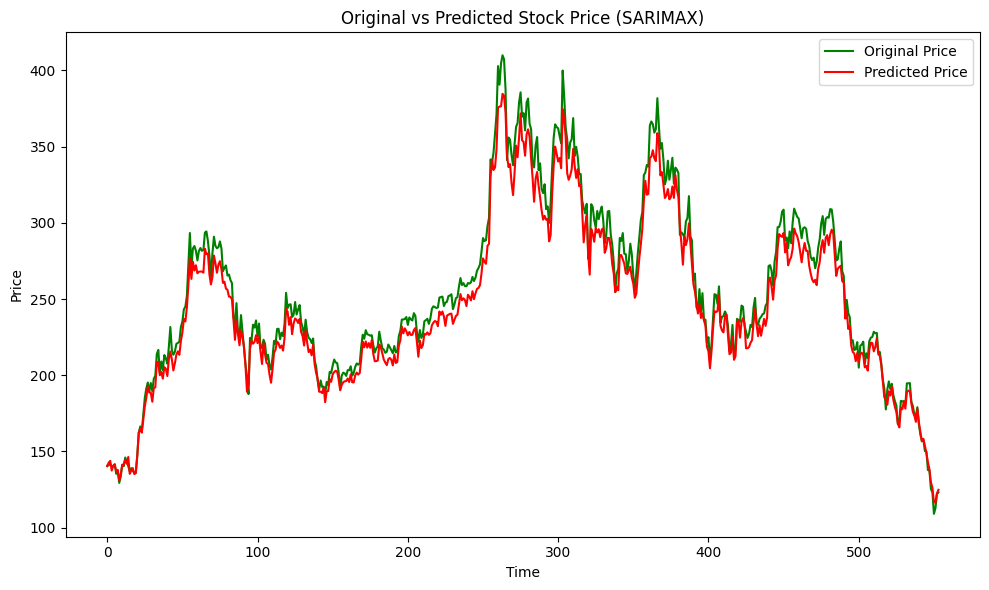


Sample Actual vs Predicted Prices:
          Date  Actual_Price  Predicted_Price
544 2022-12-16    150.229996       153.674724
545 2022-12-19    149.869995       149.039973
546 2022-12-20    137.800003       142.933891
547 2022-12-21    137.570007       138.359963
548 2022-12-22    125.349998       129.720694
549 2022-12-23    123.150002       126.167016
550 2022-12-27    109.099998       116.603422
551 2022-12-28    112.709999       116.650991
552 2022-12-29    121.820000       122.561288
553 2022-12-30    123.180000       124.815115


In [ ]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

# Input
stock = input("Enter Stock Symbol (e.g., AAPL, GOOG, TSLA): ").strip().upper()
start = '2012-01-01'
end = '2022-12-31'

# Fetch data
data = yf.download(stock, start, end)
data.reset_index(inplace=True)

print(f"\nShowing recent data for {stock}:")
print(data.tail())

# Drop missing values
data.dropna(inplace=True)

# ----- Decompose Time Series -----
print("\nDecomposing time series into trend, seasonality, and residuals...")



# Plot decomposition
decompose = seasonal_decompose(data['Close'], model='additive', period=30)
print(decompose.plot())

plt.show()

# Reset index
data.reset_index(inplace=True)

# ----- Prepare data for model -----
data_feat = data[['Close', 'Open', 'High', 'Low', 'Volume']]
data_feat.dropna(inplace=True)

# Split
data_train = data_feat[0:int(len(data_feat) * 0.80)]
data_test = data_feat[int(len(data_feat) * 0.80):]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.transform(data_test)

# Inverse scaling factor for Close price
scale_factor = 1 / scaler.scale_[0]

# ----- SARIMAX Model -----
model_path = f'{stock}_sarimax.pkl'

if not os.path.exists(model_path):
    print("\nTraining SARIMAX model...")
    endog = data_train['Close']
    exog = data_train[['Open', 'High', 'Low', 'Volume']]

    sarimax_model = SARIMAX(
        endog,
        exog=exog,
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = sarimax_model.fit(disp=False)

    # Save model
    with open(model_path, 'wb') as f:
        pickle.dump(model_fit, f)
else:
    print("\nLoading existing SARIMAX model...")
    with open(model_path, 'rb') as f:
        model_fit = pickle.load(f)

# ----- Forecasting -----
exog_forecast = data_test[['Open', 'High', 'Low', 'Volume']]
n_periods = len(data_test)

forecast = model_fit.forecast(steps=n_periods, exog=exog_forecast)
predictions = np.array(forecast)

# Actual values
y_test = data_test['Close'].values

# Metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# ----- Plot Predictions -----
plt.figure(figsize=(10, 6))
plt.plot(y_test, 'g', label='Original Price')
plt.plot(predictions, 'r', label='Predicted Price')
plt.title('Original vs Predicted Stock Price (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# ----- Show Results -----
date_range = data.iloc[data_test.index]['Date'].values

results_df = pd.DataFrame({
    'Date': date_range,
    'Actual_Price': y_test.flatten(),
    'Predicted_Price': predictions.flatten()
})

results_df.reset_index(drop=True, inplace=True)

print("\nSample Actual vs Predicted Prices:")
print(results_df.tail(10))
